# Assignment 11-2: SQL on Everything

## Objectives

In this assignment, you will learn:
* How to query a table stored in Hive using Presto Hive connector.
* How to join table from different places using Presto connectors.

## Background

Suppose you are a data scienties working for an airline company. The company has an EMR cluster in AWS with Presto and Hive deployed, and another node with PostgreSQL deployed. The Hive cluster stores a table named `flights`, which contains the flight delay data. The PostgreSQL node stores two tables named `airlines` and `airports`, which provide additional information about airlines and airports for the `flights` table. 

Please check the description of all the tables in the [table_description](table_description) folder.

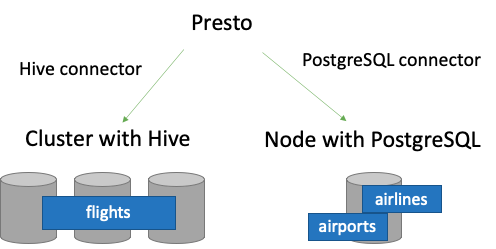


This assignment contains two parts:
- In the first part, you will use Presto to query the `flights` table in Hive. 
- In the second part, you will use Presto to join table `flights` from Hive with table `airlines` and `airports` from PostgreSQL.

For each part, you are given some questions and need to write down a **single** sql query to answer each question.

## Warmup
Please read the Data Sources section in the [documentation](https://prestodb.io/docs/current/overview/concepts.html#data-sources) to learn some basic concepts of Presto.

After you read it, you should know:
* The meanning of `connector`, `catalog`, `schema`, and `table`.
* Every catalog is associated with a specific connector. For example, the `hive` catalog is associated with an Hive connector.
* The fully-qualified table name is `<catalog>.<schema>.<table>`.

## Setup
Now, let us setup the Presto connection and test whether everything works well.
### Step 1. Install pyhive and ipython-sql
[ipython-sql](https://github.com/catherinedevlin/ipython-sql) is a jupyter notebook extension. It allows you to use SQL queries nicely inside jupyter notebooks. To use it, we also need the presto driver from [pyhive](https://github.com/dropbox/PyHive). You can easily install them using pip or Anaconda.
- Open a terminal and type `pip install pyhive ipython-sql` or `conda install -c conda-forge pyhive ipython-sql`.

### Step 2. Dowoload Connection Config

Download the config file [presto.ini](https://coursys.sfu.ca/2022sp-cmpt-733-g1/pages/Presto_Config) and put it in the `conf` folder.

### Step 2. Connect to Presto
Now we connect to Presto. We first load the `ipython-sql` module and the `get_connection_string` function from `load_config.py` file. Run the cell below:

In [1]:
from load_config import get_connection_string
%load_ext sql

Next, we load the config file and get the connection string, then config for `ipython-sql`. Note that we set autolimit to 200, which means that the result fetchs at most 200 rows.

In [2]:
cstr = get_connection_string("conf/presto.ini")
%sql $cstr
%config SqlMagic.autocommit=False
%config SqlMagic.displaycon = False
%config SqlMagic.autolimit = 200

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: UserWarning: Config option `displaycon` not recognized by `SqlMagic`.  Did you mean `displaylimit`?
  exec(code_obj, self.user_global_ns, self.user_ns)


### Step 3. Test Connection
We're ready to issue queries. The cell below shows how to display catalogs in Presto. Run it and see whether everything works:

In [3]:
%sql SHOW CATALOGS

 * presto://hadoop@ec2-18-119-118-150.us-east-2.compute.amazonaws.com:8889/hive
Done.


Catalog
awsdatacatalog
hive
postgresql
system


You should see `hive` and `postgresql` in the catalogs. They represet the Hive and PostgreSQL connectors, respectively. Now, we list the schemas in Hive using `SHOW SCHEMAS FROM <CATALOG>`:

In [4]:
%sql SHOW SCHEMAS FROM postgresql

 * presto://hadoop@ec2-18-119-118-150.us-east-2.compute.amazonaws.com:8889/hive
Done.


Schema
cmpt733
information_schema
pg_catalog
public


You should see the `cmpt733` schema. We list its table:

In [6]:
%sql SHOW TABLES FROM postgresql.cmpt733

 * presto://hadoop@ec2-18-119-118-150.us-east-2.compute.amazonaws.com:8889/hive
Done.


Table
airlines
airports


You should find the `flights` table from the above result. As we said before, table is identified by `<catalog>.<schema>.<table>`. You could access the `flights` table directly by `hive.cmpt733.flights`. Finally, let us see what's in `flights`. We list 10 rows of the table and save the result as a pandas dataframe:

In [7]:
result = %sql SELECT * FROM hive.cmpt733.flights LIMIT 10
df = result.DataFrame()
df

 * presto://hadoop@ec2-18-119-118-150.us-east-2.compute.amazonaws.com:8889/hive
Done.


,year,month,day,day_of_week,airline_code,flight_number,tail_number,origin_airport_code,destination_airport_code,scheduled_departure,...,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,2015,10,30,5,OO,5611,N706SK,12892,14679,2315,...,30.0,23.0,0,0,,0.0,0.0,5.0,18.0,0.0
1,2015,10,30,5,UA,411,N34455,12892,12264,2315,...,726.0,19.0,0,0,,19.0,0.0,0.0,0.0,0.0
2,2015,10,30,5,UA,445,N69840,14771,10821,2315,...,723.0,2.0,0,0,,NaN,NaN,NaN,NaN,NaN
3,2015,10,30,5,UA,351,N33286,14771,14747,2318,...,142.0,14.0,0,0,,NaN,NaN,NaN,NaN,NaN
4,2015,10,30,5,F9,1232,N948FR,12889,13303,2320,...,742.0,57.0,0,0,,6.0,0.0,0.0,51.0,0.0
5,2015,10,30,5,VX,34,N852VA,14771,12478,2320,...,725.0,-25.0,0,0,,NaN,NaN,NaN,NaN,NaN
6,2015,10,30,5,AS,150,N453AS,10299,12892,2320,...,515.0,-28.0,0,0,,NaN,NaN,NaN,NaN,NaN
7,2015,10,30,5,HA,466,N592HA,14222,12173,2320,...,541.0,1.0,0,0,,NaN,NaN,NaN,NaN,NaN
8,2015,10,30,5,NK,184,N503NK,12892,11042,2320,...,651.0,6.0,0,0,,NaN,NaN,NaN,NaN,NaN
9,2015,10,30,5,NK,806,N509NK,12889,10397,2320,...,557.0,-13.0,0,0,,NaN,NaN,NaN,NaN,NaN


If the SQL is long, you can use `%%sql` to run an SQL with multiple lines:

In [17]:
%%sql 
result << 
SELECT * 
FROM hive.cmpt733.flights

 * presto://hadoop@ec2-18-119-118-150.us-east-2.compute.amazonaws.com:8889/hive
Done.
Returning data to local variable result


In [18]:
result

year,month,day,day_of_week,airline_code,flight_number,tail_number,origin_airport_code,destination_airport_code,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
2015,10,30,5,OO,5611,N706SK,12892,14679,2315,2340.0,25.0,23.0,3.0,52.0,50.0,23.0,109,26.0,4.0,7,30.0,23.0,0,0,,0.0,0.0,5.0,18.0,0.0
2015,10,30,5,UA,411,N34455,12892,12264,2315,2316.0,1.0,47.0,3.0,292.0,310.0,258.0,2288,721.0,5.0,707,726.0,19.0,0,0,,19.0,0.0,0.0,0.0,0.0
2015,10,30,5,UA,445,N69840,14771,10821,2315,2307.0,-8.0,32.0,2339.0,306.0,316.0,273.0,2457,712.0,11.0,721,723.0,2.0,0,0,,None,None,None,None,None
2015,10,30,5,UA,351,N33286,14771,14747,2318,2314.0,-4.0,42.0,2356.0,130.0,148.0,98.0,679,134.0,8.0,128,142.0,14.0,0,0,,None,None,None,None,None
2015,10,30,5,F9,1232,N948FR,12889,13303,2320,11.0,51.0,17.0,28.0,265.0,271.0,249.0,2174,737.0,5.0,645,742.0,57.0,0,0,,6.0,0.0,0.0,51.0,0.0
2015,10,30,5,VX,34,N852VA,14771,12478,2320,2316.0,-4.0,10.0,2326.0,330.0,309.0,288.0,2586,714.0,11.0,750,725.0,-25.0,0,0,,None,None,None,None,None
2015,10,30,5,AS,150,N453AS,10299,12892,2320,2321.0,1.0,13.0,2334.0,323.0,294.0,273.0,2345,507.0,8.0,543,515.0,-28.0,0,0,,None,None,None,None,None
2015,10,30,5,HA,466,N592HA,14222,12173,2320,2315.0,-5.0,8.0,2323.0,320.0,326.0,312.0,2599,535.0,6.0,540,541.0,1.0,0,0,,None,None,None,None,None
2015,10,30,5,NK,184,N503NK,12892,11042,2320,2331.0,11.0,10.0,2341.0,265.0,260.0,240.0,2052,641.0,10.0,645,651.0,6.0,0,0,,None,None,None,None,None
2015,10,30,5,NK,806,N509NK,12889,10397,2320,2310.0,-10.0,15.0,2325.0,230.0,227.0,203.0,1747,548.0,9.0,610,557.0,-13.0,0,0,,None,None,None,None,None


## Part 1. Query table in Hive through Presto

Now let us explore the `flights` table and answer some questions. For each question, please write down the code below the question. For example, for question 'please list 10 rows of flights table', the answer is `%sql SELECT * FROM hive.cmpt733.flights LIMIT 10`.

### Q1.1  Which month has the shortest average departure delay? Output each month and its average departure delay. Order by the average departure delay increasingly. 

In [60]:
%%sql 
SELECT month,AVG(departure_delay) AS delay
FROM hive.cmpt733.flights 
GROUP BY month 
ORDER BY AVG(departure_delay)


 * presto://hadoop@ec2-18-119-118-150.us-east-2.compute.amazonaws.com:8889/hive
Done.


month,delay
9,4.823559775213923
10,4.982661121973602
11,6.944197242215287
4,7.721884890350968
5,9.454143844184054
3,9.66090306741507
1,9.759471188777926
8,9.93204459320268
7,11.394664197392151
12,11.783529247101587


### Q1.2  What is the most frequent cancellation reason for airlines that have been canceled more than 5000 times? Output each cancellation reason and its frequency. Order by the frequency decreasingly. Note that the empry string in *cancellation_reason* column does not count. 

In [75]:
%%sql 
SELECT cancellation_reason,COUNT(cancellation_reason) AS cnt
FROM hive.cmpt733.flights AS a
JOIN (SELECT COUNT(airline_code),airline_code
FROM hive.cmpt733.flights
WHERE cancelled=1
GROUP BY airline_code
HAVING COUNT(airline_code)>5000) AS L ON a.airline_code=L.airline_code
WHERE cancelled=1
GROUP BY cancellation_reason
ORDER BY cnt DESC

 * presto://hadoop@ec2-18-119-118-150.us-east-2.compute.amazonaws.com:8889/hive
Done.


cancellation_reason,cnt
B,39246
A,21155
C,13332
D,18


## Part 2: Query tables from different sources
In `flights` table, the *airline_code*, *origin_airport_code* and *destination_airport_code* columns are both IATA code. We want to know more information about them such as the name of airline and airport, and the location of airport. To acehive this goal, we will join `flights` with another two tables, `airlines` and `airports`, which are stored in PostgreSQL.

PostgreSQL connector uses `postgresql` catalog. The `airlines` and `airports` tables are both in the `postgresql` catalog and `cmpt733` schema.

To test, run the following two cells to see what the `airlines` and `airports` tables contain:

In [101]:
%sql SELECT * FROM postgresql.cmpt733.airlines

 * presto://hadoop@ec2-18-119-118-150.us-east-2.compute.amazonaws.com:8889/hive
Done.


iata_code,airline
UA,United Air Lines Inc.
AA,American Airlines Inc.
US,US Airways Inc.
F9,Frontier Airlines Inc.
B6,JetBlue Airways
OO,Skywest Airlines Inc.
AS,Alaska Airlines Inc.
NK,Spirit Air Lines
WN,Southwest Airlines Co.
DL,Delta Air Lines Inc.


In [45]:
%sql SELECT * FROM postgresql.cmpt733.airports

 * presto://hadoop@ec2-18-119-118-150.us-east-2.compute.amazonaws.com:8889/hive
Done.


iata_code,airport,city,state,country,latitude,longitude
ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.4404
ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.6819
ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
ACK,Nantucket Memorial Airport,Nantucket,MA,USA,41.25305,-70.06018
ACT,Waco Regional Airport,Waco,TX,USA,31.61129,-97.23052
ACV,Arcata Airport,Arcata/Eureka,CA,USA,40.97812,-124.10862
ACY,Atlantic City International Airport,Atlantic City,NJ,USA,39.45758,-74.57717
ADK,Adak Airport,Adak,AK,USA,51.87796,-176.64603


In Presto, joining tables from different sources is pretty easy. It provides a unified view to manage different data sources by using connectors. You can process them like they are in the same database. For example, in the following, we join the `airline_code` column in `flights` with `iata_code` in the `airlines` table:

In [63]:
%%sql 
SELECT f.*, L.airline
FROM hive.cmpt733.flights as F
JOIN postgresql.cmpt733.airlines as L ON F.airline_code = L.iata_code
LIMIT 1000

 * presto://hadoop@ec2-18-119-118-150.us-east-2.compute.amazonaws.com:8889/hive
Done.


year,month,day,day_of_week,airline_code,flight_number,tail_number,origin_airport_code,destination_airport_code,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,airline
2015,10,30,5,AA,1116,N023AA,12892,10397,2325,2323.0,-2.0,16.0,2339.0,258.0,258.0,232.0,1947,631.0,10.0,643,641.0,-2.0,0,0,,None,None,None,None,None,American Airlines Inc.
2015,10,30,5,AA,30,N798AA,12892,12478,2330,2332.0,2.0,42.0,14.0,329.0,346.0,298.0,2475,812.0,6.0,759,818.0,19.0,0,0,,19.0,0.0,0.0,0.0,0.0,American Airlines Inc.
2015,10,30,5,AA,1538,N877AA,12892,13303,2335,2357.0,22.0,25.0,22.0,300.0,311.0,278.0,2342,800.0,8.0,735,808.0,33.0,0,0,,11.0,0.0,4.0,18.0,0.0,American Airlines Inc.
2015,10,30,5,AA,485,N802AW,10299,14107,2340,2341.0,1.0,20.0,1.0,327.0,306.0,283.0,2552,544.0,3.0,607,547.0,-20.0,0,0,,None,None,None,None,None,American Airlines Inc.
2015,10,30,5,AA,2461,N3GXAA,13303,13204,2349,2351.0,2.0,16.0,7.0,62.0,56.0,34.0,192,41.0,6.0,51,47.0,-4.0,0,0,,None,None,None,None,None,American Airlines Inc.
2015,10,30,5,AA,1763,N538UW,14893,11057,2350,2349.0,-1.0,12.0,1.0,278.0,264.0,248.0,2244,709.0,4.0,728,713.0,-15.0,0,0,,None,None,None,None,None,American Airlines Inc.
2015,10,30,5,AA,219,N3LWAA,12892,13930,2359,2355.0,-4.0,26.0,21.0,242.0,242.0,208.0,1744,549.0,8.0,601,557.0,-4.0,0,0,,None,None,None,None,None,American Airlines Inc.
2015,10,30,5,AA,272,N3HMAA,14771,13303,2359,2400.0,1.0,20.0,20.0,318.0,327.0,298.0,2585,818.0,9.0,817,827.0,10.0,0,0,,None,None,None,None,None,American Airlines Inc.
2015,10,30,5,AA,1283,N3HJAA,14747,13930,2359,317.0,198.0,19.0,336.0,226.0,224.0,190.0,1721,846.0,15.0,545,901.0,196.0,0,0,,0.0,0.0,196.0,0.0,0.0,American Airlines Inc.
2015,10,30,5,AA,1522,N3EBAA,14771,13930,2359,2400.0,1.0,12.0,12.0,240.0,230.0,213.0,1846,545.0,5.0,559,550.0,-9.0,0,0,,None,None,None,None,None,American Airlines Inc.


Next, let us use the `flights` table as well as the `airlines` and `airports` tables to answer the following questions. The answer to each question should be **a single SQL query**.

### Q2.1  What is the average arrival delay for each airline on weekends (Satursday and Sunday)? Output the name of each airline with its average delay. Order by the delay increasingly. 

In [79]:
%%sql
SELECT L.airline,AVG(f.arrival_delay) AS avg_delay
FROM hive.cmpt733.flights as f
JOIN postgresql.cmpt733.airlines as L ON f.airline_code = L.iata_code
WHERE day_of_week=6 or day_of_week=7
GROUP BY airline
ORDER BY avg_delay

 * presto://hadoop@ec2-18-119-118-150.us-east-2.compute.amazonaws.com:8889/hive
Done.


airline,avg_delay
Delta Air Lines Inc.,-1.949872580260952
Alaska Airlines Inc.,-1.5681931931931932
Hawaiian Airlines Inc.,1.504537374871363
American Airlines Inc.,2.6937418588714106
US Airways Inc.,2.821527859352363
United Air Lines Inc.,3.112868326842126
Southwest Airlines Co.,3.1754479105834004
Virgin America,4.463780183180683
Atlantic Southeast Airlines,4.500028700169331
American Eagle Airlines Inc.,4.626345990857683


### Q2.2 Find the average canceled rate of the days (Monday - Sunday) for the flights from Columbia to Chicago in February. Output the days and the average canceled rates

In [78]:
%%sql
SELECT a.day_of_week,AVG(a.cancelled) as avg_cancellation_rate
FROM hive.cmpt733.flights as a
JOIN postgresql.cmpt733.airports as L ON a.origin_airport_code = L.iata_code
JOIN postgresql.cmpt733.airports as B ON a.destination_airport_code = B.iata_code
WHERE a.month=2 and L.city='Columbia' and B.city='Chicago'
GROUP BY a.day_of_week
ORDER BY a.day_of_week

 * presto://hadoop@ec2-18-119-118-150.us-east-2.compute.amazonaws.com:8889/hive
Done.


day_of_week,avg_cancellation_rate
1,0.125
2,0.0
3,0.0625
4,0.0625
5,0.0
6,0.08333333333333333
7,0.2


### Q2.3 How many unique flights (flight number) are from New York to Houston by United Air Lines Inc. on each day (Monday - Sunday)? Output the number of unique flights for each day of week (Monday - Sunday). Order by "day_of_week" increasingly.

In [83]:
%%sql
SELECT a.day_of_week,COUNT(DISTINCT a.flight_number) as unique_flights_count
FROM hive.cmpt733.flights as a
JOIN postgresql.cmpt733.airlines as L ON a.airline_code = L.iata_code
JOIN postgresql.cmpt733.airports as L1 ON a.origin_airport_code = L1.iata_code
JOIN postgresql.cmpt733.airports as B ON a.destination_airport_code = B.iata_code
WHERE L1.city='New York' and B.city='Houston' and L.airline='United Air Lines Inc.'
GROUP BY a.day_of_week
ORDER BY a.day_of_week

 * presto://hadoop@ec2-18-119-118-150.us-east-2.compute.amazonaws.com:8889/hive
Done.


day_of_week,unique_flights_count
1,64
2,62
3,68
4,62
5,72
6,61
7,61


### Q2.4 For each origin city, find the percentage of departing flights whose distance is larger than 1000. Return the name of the city and the percentage value. Order by city.

In [39]:
%%sql
SELECT L.city, (ROUND(COUNT(a.tail_number)+0.0000,3)/ROUND(B.percent+0.0000,3))*100 as percentage
FROM hive.cmpt733.flights as a
JOIN postgresql.cmpt733.airports as L ON a.origin_airport_code = L.iata_code
JOIN (SELECT L1.city, COUNT(a1.tail_number) as percent,L1.iata_code FROM hive.cmpt733.flights as a1
JOIN postgresql.cmpt733.airports as L1 ON a1.origin_airport_code = L1.iata_code
GROUP BY L1.city,L1.iata_code) as B ON a.origin_airport_code=B.iata_code
WHERE a.distance>1000
GROUP BY L.city,B.percent
ORDER BY L.city

 * presto://hadoop@ec2-18-119-118-150.us-east-2.compute.amazonaws.com:8889/hive
Done.


city,percentage
Adak,100.0000
Agana,100.0000
Aguadilla,87.7900
Akron,5.2500
Albany,22.8900
Albuquerque,18.9100
Anchorage,68.4800
Arlington,21.1000
Aspen,20.2700
Atlanta,10.9400


### Q2.5: If there exists a direct flight from city A to city X and city X to city B, then city X is called a stop city from A to B. List all stop cities from Seattle to Houston (not include Seattle and Houston). Order results alphabetically.

In [70]:
%%sql
SELECT DISTINCT L3.city
FROM hive.cmpt733.flights as L1
JOIN postgresql.cmpt733.airports as L2 ON L1.origin_airport_code = L2.iata_code
JOIN postgresql.cmpt733.airports as L3 ON L1.destination_airport_code = L3.iata_code
JOIN (SELECT a.origin_airport_code
FROM hive.cmpt733.flights as a
JOIN postgresql.cmpt733.airports as L ON a.destination_airport_code = L.iata_code
WHERE L.city='Houston') AS L5 ON L1.destination_airport_code=L5.origin_airport_code
WHERE L2.city='Seattle' and L3.city<>'Houston'
ORDER BY L3.city

 * presto://hadoop@ec2-18-119-118-150.us-east-2.compute.amazonaws.com:8889/hive
Done.


city
Albuquerque
Anchorage
Arlington
Atlanta
Austin
Baltimore
Boise
Boston
Bozeman
Chantilly


## Reading (Optional)

* Sethi, Raghav, et al. "[Presto: SQL on Everything](https://research.fb.com/wp-content/uploads/2019/03/Presto-SQL-on-Everything.pdf)" 2019 IEEE 35th International Conference on Data Engineering (ICDE). IEEE, 2019.
* [OpenLookEng](https://openlookeng.io/) is an open-source tool built on top of Presto, released by Huawei Technologies Co., Ltd. It improves Presto's performance with several optimizations, such as Heuristic Index, Adaptive Dynamic Filter, Cross Region Connector, .... You can try it out at https://tryme.openlookeng.io/.



## Submission

Complete the code in A11-2.ipynb, and submit it to the CourSys activity Assignment 11.

